# set up

In [1]:
#connect to gdrive
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive
#%cd ../..
!pwd

Mounted at /content/gdrive
/content/gdrive/MyDrive
/content/gdrive/MyDrive


In [ ]:
#%cd competitions/hw5
!ls

'Colab Notebooks'	  large_hr	 netd_report7   netg_report6
 comics			  large_test	 netd_report8   netg_report7
 DIV2K_train_HR		  netd_report1	 netd_SRGAN     netg_report8
 DIV2K_train_LR_bicubic   netd_report2	 netg_report1   netg_SRGAN
 DIV2K_valid_HR		  netd_report3	 netg_report2   structures
 DIV2K_valid_LR_bicubic   netd_report4	 netg_report3   test_out
 HW5_test		  netd_report5	 netg_report4   wandb
 HW5_train_val.zip	  netd_report6	 netg_report5


In [ ]:
#!unzip HW5_train_val.zip
#!unzip sample_submission.zip

In [ ]:

#!unzip DIV2K_train_HR.zip
#!unzip DIV2K_train_LR_bicubic_X4.zip
#!unzip DIV2K_valid_HR.zip
#!unzip DIV2K_valid_LR_bicubic_X4.zip

# pre-processing


In [2]:
from torch.autograd import Variable
import torch.optim as optim
from PIL import Image
import PIL.ImageOps  
from torchvision import transforms
import numpy as np
from os import listdir
import torchvision
import torch
from torchvision.utils import save_image
from torch import nn
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image, ImageFilter
import torchvision.transforms.functional 
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
import matplotlib.pyplot as plt

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [3]:

def is_image(filename):
  return any(filename.endswith(extension) for extension in ['png'])


class TrainDataset(object):
    def __init__(self,lrimagefolder,hrimagefolder,transform=None,should_invert=False, test = False):
        super(TrainDataset,self).__init__()
        
        self.hrimagefolder = hrimagefolder
        self.lrimagefolder = lrimagefolder  
        if transform:
          self.transformhr = transform[0]
          self.transformlr = transform[1]
        else:
          self.transformhr = None
          self.transformlr = None
        self.should_invert = should_invert
        self.hrdir = sorted(listdir(hrimagefolder))
        self.lrdir = sorted(listdir(lrimagefolder))


        self.test = test


    def __getitem__(self,index):

        dirnamehr =  self.hrimagefolder + '/' + self.hrdir[index]
        dirnamelr =  self.lrimagefolder + '/' + self.lrdir[index]


        imghr = Image.open(dirnamehr)
        imglr = Image.open(dirnamelr)


        if self.transformhr is not None:

          imghr = self.transformhr(imghr)
          imglr = self.transformlr(imglr)

        p = np.random.random()

        if p > 0.5:
            imglr = torchvision.transforms.functional.hflip(imglr)
            imghr = torchvision.transforms.functional.hflip(imghr)

        # Randomly change the brightness, contrast, saturation and hue of an image.
        imglr = torchvision.transforms.functional.adjust_brightness(imglr, brightness_factor=p)
        imglr= torchvision.transforms.functional.adjust_contrast(imglr, contrast_factor=p)

        imghr = torchvision.transforms.functional.adjust_brightness(imghr, brightness_factor=p)
        imghr = torchvision.transforms.functional.adjust_contrast(imghr, contrast_factor=p)

       
        imghr = transforms.ToTensor()(imghr)
        imglr = transforms.ToTensor()(imglr)

      
        if self.test == False:
          return imghr, imglr
    
        
    
    def __len__(self):
        return len(self.hrdir)

In [4]:
import torchvision
crop_size = 800
upscale_factor = 4
t = [torchvision.transforms.Compose([transforms.CenterCrop(800),]),torchvision.transforms.Compose([transforms.CenterCrop(200),])]

lrimagefolder = 'DIV2K_train_LR_bicubic/X4'
hrimagefolder = 'DIV2K_train_HR'
train_dataset = TrainDataset(lrimagefolder, hrimagefolder, transform=t)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle = True, num_workers = 0, batch_size = 4)
lrimagefolder = 'DIV2K_valid_LR_bicubic/X4'
hrimagefolder = 'DIV2K_valid_HR'
t = [torchvision.transforms.Compose([transforms.CenterCrop(600),]),torchvision.transforms.Compose([transforms.CenterCrop(150),])]

valid_dataset = TrainDataset(lrimagefolder, hrimagefolder, transform=t)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle = False, num_workers = 0, batch_size = 1)


torch.Size([1, 3, 600, 600]) torch.Size([1, 3, 150, 150])
torch.Size([1, 3, 150, 150])
torch.Size([1, 3, 600, 600]) torch.Size([1, 150, 3, 150])


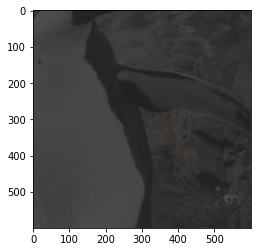

In [5]:

for a, b in valid_dataloader:
  print(a.shape, b.shape)
  _,w,h,_ = b.shape
  trans = torchvision.transforms.Compose([Resize((w,h)),]) 
  transa = a

  plt.imshow(a[0].permute(1, 2, 0))
  #plt.imshow(b[0])
  print(b.shape)
  print(a.shape, b.permute(0,3,1,2).shape)

  del a
  del b
  break

# model

In [6]:
#residual block
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels ,stride=1, downsample = False):
        super(ResidualBlock, self).__init__()
        self.downsample = downsample
        self.expansion = 1
        self.conv1 = nn.Conv2d(in_channels, out_channels,kernel_size = 1,stride = 1, padding = 0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.PReLU()
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size = 3,stride = stride, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        
        self.shortcut = nn.Sequential()
        if downsample == False:
            self.shortcut = nn.Identity()
        else:
            self.shortcut = nn.Conv2d(in_channels,out_channels, kernel_size=1, stride=stride)
            self.bn3 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
      
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample == True:
          shortcut = self.bn3(self.shortcut(x))
        else:
          shortcut = self.shortcut(x)

        out = self.relu(out + shortcut)
        return out

In [7]:
class upsampleblock(torch.nn.Module):
  def __init__(self, in_channel, scale = 2):
    super(upsampleblock, self).__init__()
    self.conv = nn.Conv2d(in_channel, in_channel *scale * 2, kernel_size = 3, stride = 1, padding = 1)
    self.pixel_shuffle = nn.PixelShuffle(upscale_factor = scale)
    self.prelu = nn.PReLU()
  
  def forward(self, x):
    x = self.conv(x)
    x = self.pixel_shuffle(x)
    x = self.prelu(x)
    return x

In [8]:
import math
import torch.nn as nn

class Generator(torch.nn.Module):
  def __init__(self, scale_factor=4, numblock = 8):
    super(Generator,self).__init__()
    upsample_num = 2 #int(math.log(scale_factor, 2))

    self.block1 = nn.Sequential(nn.Conv2d(3,64,kernel_size = 9, stride = 1,padding = 4),  
                                nn.PReLU(),)

    resblock = []
    for _ in range(numblock):
      resblock.append(ResidualBlock(64,64, stride = 1, downsample = True))
    self.resblock = nn.Sequential(*resblock)

    self.block3 = nn.Sequential(nn.Conv2d(64,64,kernel_size = 3, padding = 1),
                                nn.BatchNorm2d(64),) 

    upblock = []
    for _ in range(upsample_num):
      upblock.append(upsampleblock(64))
    upblock.append(nn.Conv2d(64,3,kernel_size = 9, padding = 4)) 
    self.upblock = nn.Sequential(*upblock)

  def forward(self,x):

    x = self.block1(x)
    xb4 = x.clone()

    x = self.resblock(x)
    x = self.block3(x)

    x = torch.nn.functional.relu(x + xb4)

    x = self.upblock(x)
    return torch.tanh(x)



In [9]:
class Discriminator(torch.nn.Module):
  def __init__(self):
    super().__init__()
    block_channel = [64, 128, 256, 512]#original: 64, 128, 256, 512

    longblock = []
    inchannel = 3
    out = 64
    for b in range(len(block_channel)):
      out = block_channel[b]
      if b == 0:
        longblock.append(nn.Conv2d(inchannel,out, kernel_size = 3, stride = 1, padding = 1))
        longblock.append(nn.LeakyReLU(0.2))
      else:
        longblock.append(nn.Conv2d(inchannel,out, kernel_size = 3, stride = 1, padding = 1))
        longblock.append(nn.BatchNorm2d(out))
        longblock.append(nn.LeakyReLU(0.2))
      inchannel = out
      longblock.append(nn.Conv2d(inchannel,out, kernel_size = 3, stride = 2, padding = 1))
      longblock.append(nn.BatchNorm2d(out))
      longblock.append(nn.LeakyReLU(0.2))
    
    self.longblock = nn.Sequential(*longblock)
    
    self.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(512, 1024, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(1024,1, kernel_size = 1) 
    )

  def forward(self,x):

    x = self.longblock(x)
    x = self.classifier(x)
    x = x.flatten(start_dim = 1)
    return torch.sigmoid(x)


# training

In [ ]:
from torch import nn
from torchvision.models.vgg import vgg19

In [10]:

class GeneratorLoss(nn.Module):
    def __init__(self, before_act = True):
        super(GeneratorLoss, self).__init__()
        vgg = vgg19(pretrained=True)
        vggloss= nn.Sequential(*list(vgg.features)[:7]).eval()  
        for param in vggloss.parameters():
            param.requires_grad = False
        self.vggloss = vggloss.to(device)

        self.mse_loss = nn.MSELoss().to(device)

    def forward(self, out_labels, out_images, target_images):
        # Adversarial Loss
        adversarial_loss = torch.mean(1 - out_labels)

        # Perception Loss
        vgg_loss = self.mse_loss(self.vggloss(out_images), self.vggloss(target_images))

        # Image Loss
        image_loss = self.mse_loss(out_images, target_images)

        return image_loss + 0.001*adversarial_loss + 0.006*vgg_loss
        

In [11]:

def training(epoch, G_optimizer, D_optimizer, lr,netG, netD, train_dataloader):
  gloss = 0
  dloss = 0
  dscore = 0
  gscore = 0

  netG.train()
  netD.train()
  
  for imagehr, imagelr in train_dataloader:

    g_update = True
    batch_size = imagelr.size(0)

    ##########################################discriminator##############################################
    imagehr = Variable(imagehr).to(device)
    imagelr = Variable(imagelr).to(device)   
   
    torch.cuda.empty_cache()

    D_optimizer.zero_grad()

    real_label = torch.full(size=(len(imagehr),), fill_value=0.99, dtype=torch.float, device=device)
    realout = netD(imagehr).view(-1)

    err_D_real = dcriterion(realout, real_label)
    err_D_real.backward()

    fake_label = torch.full(size=(len(imagehr),), fill_value=0, dtype=torch.float, device=device)
    fakeimg = netG(imagelr)
    
    fakeout = netD(fakeimg.detach()).view(-1)
    err_D_fake = dcriterion(fakeout, fake_label)
    err_D_fake.backward()

    D_optimizer.step()
    
    dloss += err_D_fake.item() + err_D_real.item()
    
    
    del realout
    del real_label
    del err_D_real
  
    del fakeout
    
    #############################################generator#####################################################
  
    torch.cuda.empty_cache()
    G_optimizer.zero_grad()

    # criterion
    fakeout = netD(fakeimg)
    g_loss = gcriterion(fakeout, fakeimg, imagehr)
    

    gloss += g_loss.item()
    g_loss.backward(retain_graph=True)
    G_optimizer.step()

    del imagehr
    del fakeout
    del fakeimg
    del g_loss
    
  
  print('epoch',epoch,'gloss: ', gloss, ' dloss:', dloss)


import numpy as np
import cv2
from math import log10

def val(netG, netD, valid_dataloader=None):
  netG.eval()
  netD.eval()

  psnr_total = []
  ssim_total = []

  with torch.no_grad():
    for imagehr, imagelr in valid_dataloader:
 

      imagehr = Variable(imagehr).to(device)
      imagelr = Variable(imagelr).to(device)   
      fakeimg = netG(imagelr)
 
      s = ssim(imagehr, fakeimg)
      ssim_total.append(s.item())

      p =  ((imagehr - fakeimg) ** 2).data.mean()
      psnr = 10 * log10(1 / p)
      psnr_total.append(psnr)

      del imagehr
      del imagelr
      del fakeimg
      torch.cuda.empty_cache()

    print('psnr: ',np.mean(psnr_total), 'ssim: ',np.mean(ssim_total))
    scheduler.step(np.mean(ssim_total))
    return np.mean(psnr_total)
   

# Tuning

In [ ]:
#This part is the source code 
from math import exp
import torch
import torch.nn.functional 
from torch.autograd import Variable



def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()


def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window


def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = torch.nn.functional.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = torch.nn.functional.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = torch.nn.functional.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = torch.nn.functional.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = torch.nn.functional.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)


class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)

            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)

            self.window = window
            self.channel = channel

        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)


def ssim(img1, img2, window_size=11, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    return _ssim(img1, img2, window, window_size, channel, size_average)

In [ ]:
from torch.autograd import Variable
import torch.optim as optim


netG = Generator()
netD = Discriminator()
netG.to(device)
netD.to(device)

lr = 0.0003
epochs = 30
best_val = 20


gcriterion = GeneratorLoss()
dcriterion = torch.nn.BCELoss()

G_optimizer = optim.Adam(netG.parameters(), lr = lr, betas = (0.5, 0.9))
D_optimizer = optim.Adam(netD.parameters(), lr = lr, betas = (0.5, 0.9))
scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(D_optimizer, 'min', 0.75,2)

for epoch in range(epochs):
  training(epoch, G_optimizer, D_optimizer, lr,netG, netD, train_dataloader)
  curval = val(netG, netD, valid_dataloader)
  if curval > best_val:
    torch.save(netG,'netg_report')
    torch.save(netD,'netd_report')
    print('saving model...')
    best_val = curval



epoch 0 gloss:  4.566109411884099  dloss: 276.33078268170357
psnr:  17.614635311448634 ssim:  0.49636036485433577
epoch 1 gloss:  2.4099079980514944  dloss: 273.516650646925
psnr:  20.712885185722808 ssim:  0.5521586143970489
saving model...
epoch 2 gloss:  2.070616468321532  dloss: 174.7973272795789
psnr:  20.990605651377358 ssim:  0.5740824282169342
saving model...
epoch 3 gloss:  1.9558800868690014  dloss: 145.7227777086664
psnr:  21.396010912075226 ssim:  0.570060627758503
saving model...
epoch 4 gloss:  1.891855536494404  dloss: 106.77803820034023
psnr:  20.82166049548648 ssim:  0.5823910257220268
epoch 5 gloss:  1.847430219873786  dloss: 63.20088540823781
psnr:  21.4248987931644 ssim:  0.587917346060276
saving model...
epoch 6 gloss:  1.8199758306145668  dloss: 38.2145742884386
psnr:  20.94803119740163 ssim:  0.5599519976973534
epoch 7 gloss:  1.793636623537168  dloss: 37.56522937569389
psnr:  20.43542966825958 ssim:  0.5602932718396186
epoch 8 gloss:  1.7581041692756116  dloss: 

In [ ]:
torch.save(netG,'netg_report3')
torch.save(netD,'netd_report3')

#test

In [ ]:

  #del train_dataloader
  #del valid_dataloader
#netG = torch.load('netg_SRGAN')
#netD = torch.load('netd_SRGAN')
netG = netG.to(device)
netD = netD.to(device)

In [ ]:
class TestDataset(object):
    def __init__(self,lrimagefolder,transform=None,should_invert=False, test = False):
        super(TestDataset,self).__init__()
      
        self.lrimagefolder = lrimagefolder  
        if transform:
          self.transformlr = transform[0]
        else:
          self.transformlr = None
        self.should_invert = should_invert
        self.lrdir = sorted(listdir(lrimagefolder))
        
  

        self.test = test


    def __getitem__(self,index):

        dirnamelr =  self.lrimagefolder + '/' + self.lrdir[index]

        imglr = Image.open(dirnamelr)
        
        origisize = transforms.ToTensor()(imglr)
        print(origisize.shape)


        if self.transformlr is not None:

          imglr = self.transformlr(imglr)
        imglr = transforms.ToTensor()(imglr)

        return imglr, dirnamelr, origisize.shape[1]*4, origisize.shape[2]*4
    
        
    
    def __len__(self):
        return len(self.lrdir)

In [ ]:

lrimagefolder = ['large_test']#'comics','small_test','large_test', 'structures'
#lrimagefolder = ['DIV2K_valid_LR_bicubic/X4/']
#t = [torchvision.transforms.Compose([transforms.CenterCrop(400),]),torchvision.transforms.Compose([transforms.CenterCrop(100),])]
t = [torchvision.transforms.Compose([Resize((200,200), interpolation=Image.BICUBIC),])]
for folder in lrimagefolder:
  test_dataset = TestDataset(folder,transform=t)
  test_dataloader = torch.utils.data.DataLoader(test_dataset,shuffle = False, num_workers = 0, batch_size = 1)
  
  

  for imagelr,dirnamelr, w, h in test_dataloader:
    imagelr = imagelr.to(device)   
    if imagelr.shape[1] == 1:
      imagelr = torch.stack([imagelr, imagelr, imagelr],dim = 2).squeeze(0)
    
    fakeimg = netG(imagelr) 
    fakeimg = fakeimg.cpu()
    fname = 'test_out/' + dirnamelr[0]

    
   
    save_image(fakeimg[0], fname)
    del imagelr
    del fakeimg
    del dirnamelr
  


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


torch.Size([3, 121, 81])
torch.Size([3, 121, 81])
torch.Size([3, 121, 81])
torch.Size([3, 81, 121])
torch.Size([3, 81, 121])
torch.Size([3, 81, 121])
torch.Size([3, 81, 121])
torch.Size([3, 81, 121])
torch.Size([3, 81, 121])
torch.Size([3, 81, 121])
torch.Size([3, 81, 121])
torch.Size([3, 81, 121])
torch.Size([3, 81, 121])
torch.Size([3, 81, 121])
torch.Size([3, 81, 121])
torch.Size([3, 81, 121])
torch.Size([3, 81, 121])
torch.Size([3, 81, 121])
torch.Size([3, 81, 121])
torch.Size([3, 81, 121])
torch.Size([3, 121, 81])


KeyboardInterrupt: ignored